In [1]:
# Default Libraries
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## 近似推論手法
事後分布の近似推論法
- マルコフ連鎖モンテカルロ法（MCMC）
- 変分推論法

Bayes推論が真価を発揮するような複雑な Model においては、事後分布を解析的に求めることは難しく、Parameter の事後分布の近似推論が必要になる。

### マルコフ連鎖モンテカルロ法（MCMC: Markov chain Monte Carlo methods）
Parameter の事後分布を明示的に求める代わりに、事後分布に従う乱数（Sample）を得ることで分布の性質を確認する手法。
事後分布に従う Sample を得ることで、事後分布で関心のある統計量を求めることができる。

| 用語                            | 内容                       |
|-------------------------------|--------------------------|
| マルコフ連鎖（Markov Chain）          | 確率変数の系列において、１つ前の値（状態）に基づき、次の値（状態）が決まる場合の系列のこと。 |
| 遷移確率（Transition Probability）  | １つ前の値のとき次の値になる条件確率       |
| 定常分布（Stationary Distribution） | Markov連鎖において十分な期間の経過後、変化しなくなった確率分布 |
| エルゴード性（ergodicity）            | 初期値にかかわらず、定常分布に収束する性質。   |

### モンテカルロ法（Monte Carlo Method）
乱数を用いた数値計算の総称。乱数は、確率分布に従って生成される Random な値。

In [2]:
# Example: 平均0, 標準偏差1 の Gauss分布N(0, 1)(=標準正規分布)の確率密度関数f(z) の [-2, 2]の区間での積分を計算
def montecarlo(M, trial=100, seed=1):
    """
    M個の sample による Montecarlo法を trial回繰り返し、推定値の平均と標準偏差を返す
    :param M: Sample数
    :param trial: 試行回数
    :param seed: 乱数の種
    :return: 推定値の平均と標準偏差
    """
    np.random.seed(seed)
    x = np.random.uniform(-2, 2, (M, trial))
    res = 4 * stats.norm(0, 1).pdf(x).mean(axis=0)
    return res.mean(), res.std()

ground truth: 0.9545
M= 100, estimation: 0.9574 ± 0.0426
M= 1000, estimation: 0.9520 ± 0.0144
M= 10000, estimation: 0.9548 ± 0.0048
M= 100000, estimation: 0.9543 ± 0.0015


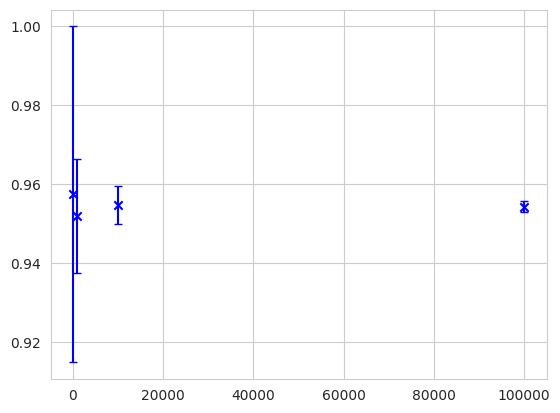

In [4]:
# 求めたい積分値の真の値
ground_truth = stats.norm(0, 1).cdf(2) - stats.norm(0, 1).cdf(-2)
print(f"ground truth: {ground_truth:.4f}")

M_list = [100, 1_000, 10_000, 100_000]
fig, ax = plt.subplots()
for M in M_list:
    m, s = montecarlo(M)
    print(f"M= {M}, estimation: {m:.4f} ± {s:.4f}")
    ax.scatter(M, m, c="b", marker="x")
    ax.errorbar(M, m, s, capsize=3, c="b")

### MCMC の Algorithm
興味のある Parameter の事後分布（目標分布）が定常分布になるように、うまく Markov連鎖の遷移確率を設計し、目標分布からの Sample を取得する。
- **詳細釣り合い条件（Detailed Balance Condition）** によって、Markov連鎖が目標分布に収束することが知られている。
- 一般的に MCMC は釣り詳細釣り合い条件を満たしている。（厳密にいうと満たさない Algorithm もある。）
- 各 MCMC-Algorithm の違いは詳細釣り合い条件を満たす遷移確率の作り方にある。

### メトロポリス・ヘイスティングス法（MH法: Metropolis-Hastings Algorithm）
- **提案分布（Proposal Distribution）** を導入し、提案分布から得られた Sample を Metropolis-Hastings基準という判定法に従い受容or棄却することによって詳細釣り合い条件を満たし目標分したがう１ Sample を得る。
- 提案分布に従う Sample（乱数）を用いた近似計算という意味で、Montecarlo法の一種と言える。
- 提案分布として Gauss分布を用いた手法は **ランダムウォークMH法** と呼ばれる。